In [86]:
import torch
import torch.nn as nn

In [87]:
torch.__version__

'2.1.0+cu121'

In [88]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [89]:
!nvidia-smi

Wed Mar 13 17:11:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#Get Data

Our dataset is a subset of the Food 101 dataset.


Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).
Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).


Why do this?


When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.


The whole point is to speed up how fast you can experiment.

In [90]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path/"pizza-steak-sushi"

#"Creating directory : "
if image_path.is_dir():
  print(f" {image_path} The path aldready exists")
else:
  print(f"{image_path} doesn't exist , creating one")
  image_path.mkdir(parents = True , exist_ok = True)

with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading , pizza , steak , sushi data..")
  f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip" , "r") as zip_ref:
  print("Unzipping : ")
  zip_ref.extractall(image_path)

 data/pizza-steak-sushi The path aldready exists
Unzipping : 


#Data preparation and data Exploration

In [91]:
import os

def walk_through_dir(dir_path):
  for dirpath,dirname,filename in os.walk(dir_path):
    print(f"{len(dirname)} directories and {len(filename)} images in {dirpath}")

In [92]:
walk_through_dir(image_path)

2 directories and 0 images in data/pizza-steak-sushi
3 directories and 0 images in data/pizza-steak-sushi/train
0 directories and 78 images in data/pizza-steak-sushi/train/pizza
0 directories and 75 images in data/pizza-steak-sushi/train/steak
0 directories and 72 images in data/pizza-steak-sushi/train/sushi
3 directories and 0 images in data/pizza-steak-sushi/test
0 directories and 25 images in data/pizza-steak-sushi/test/pizza
0 directories and 19 images in data/pizza-steak-sushi/test/steak
0 directories and 31 images in data/pizza-steak-sushi/test/sushi


In [93]:
#Set up train and testing paths

train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir , test_dir

(PosixPath('data/pizza-steak-sushi/train'),
 PosixPath('data/pizza-steak-sushi/test'))

#Visualizing image

1. Get all of the image paths


2. Pick a random image path using Python's random.choice()


3. Get the image class name using pathlib. Path.parent.stem


4. Since we're working with images, let's open the image with Python's PIL


5. We'll then show the image and print metadata

Random image path : data/pizza-steak-sushi/train/pizza/1649276.jpg
Image class : pizza
Image height : 384
Image width : 512


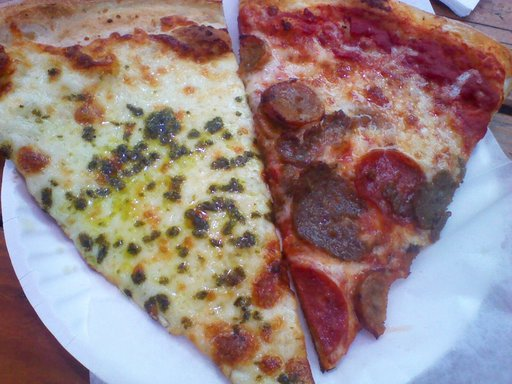

In [94]:
import random
from PIL import Image

#Setting up reproducability
random.seed(42)

#Get all image path
image_path_list = list(image_path.glob("*/*/*"))

#Picking a random image path
random_image_path = random.choice(image_path_list)

#Get the class name of the image
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Random image path : {random_image_path}")
print(f'Image class : {image_class}')
print(f'Image height : {img.height}')
print(f"Image width : {img.width}")
img

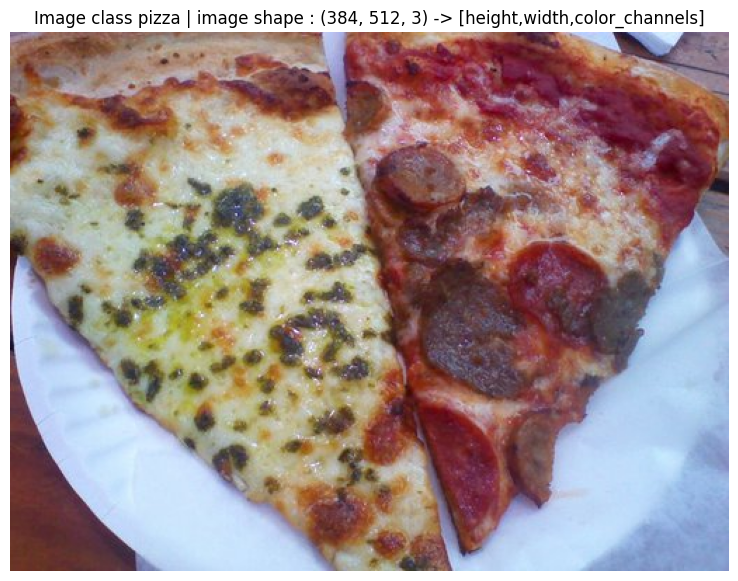

In [95]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class {image_class} | image shape : {img_as_array.shape} -> [height,width,color_channels]")
plt.axis(False);

#Transforming data to tensors

1. Turn your target data into tensors (in our case, numerical representation of our images).


2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and
DataLoader.

In [96]:
from torch.utils.data import DataLoader
from torchvision import datasets , transforms

In [97]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [98]:
data_transform(img).shape

torch.Size([3, 64, 64])

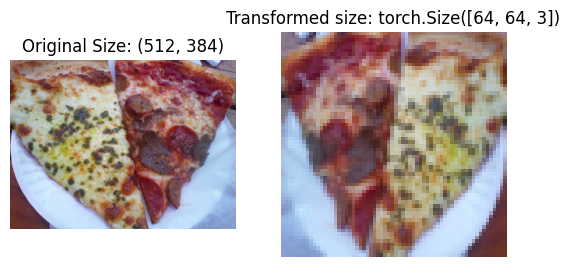

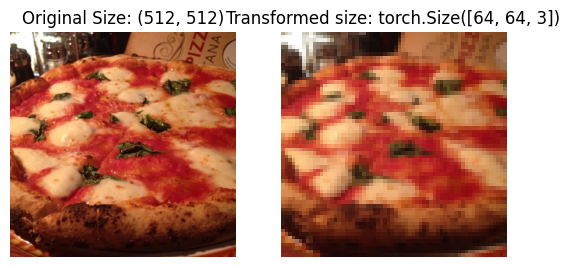

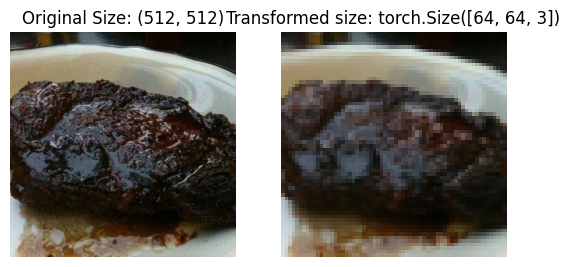

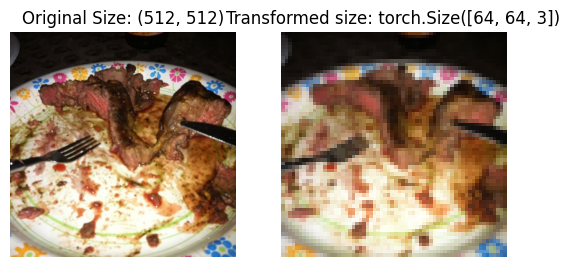

In [99]:
def plot_transformed_images(image_paths , transform , n , seed):
  random.seed(42)
  random_image = random.sample(image_path_list , k = n)
  for i in random_image:
    with Image.open(i) as f:
      fig , ax = plt.subplots(nrows = 1 , ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original Size: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed size: {transformed_image.shape}")
      ax[1].axis(False)

plot_transformed_images(image_paths = image_path_list , transform =
                        data_transform , n = 4 ,
                        seed = 42)

#Using ImageFolders to create Datasets

In [100]:
from torchvision import datasets
train_data = datasets.ImageFolder(
    root = train_dir,
    transform = data_transform,
    target_transform = None,
)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform = data_transform,
    target_transform = None
)

In [101]:
test_dir

PosixPath('data/pizza-steak-sushi/test')

In [102]:
train_data , test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza-steak-sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza-steak-sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [103]:
#Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [104]:
#Get class names as dict
class_names_dict = train_data.class_to_idx
class_names_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [105]:
#Get the length of the data
print(f"Length of train_data : {len(train_data)}")
print(f"Length of test_data : {len(test_data)}")

Length of train_data : 225
Length of test_data : 75


In [106]:
#Index on the train_data Dataset to get a single image and label
img , label = train_data[0][0] , train_data[0][1]

In [107]:
img.shape

torch.Size([3, 64, 64])

Text(0.5, 1.0, 'pizza')

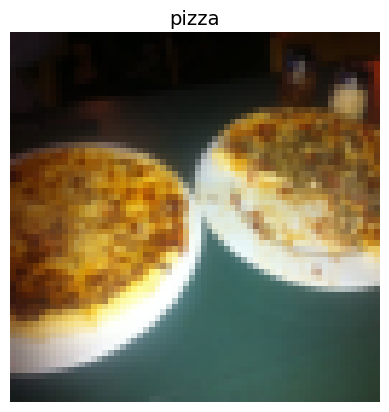

In [108]:
img_permute = img.permute(1,2,0)
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label] , fontsize = 14)

#Turn loaded images into DataLoader's
A DataLoader is going to help us turn our Dataset 's into iterables and we can customise the batch_size so our model can see batch_size
images at a time.

In [109]:
import os
os.cpu_count()

2

In [110]:
#Turn train and test datasets into DataLoader's4
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset = train_data , batch_size = 32 ,
                              num_workers = os.cpu_count(),
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data , batch_size = 32,
                             num_workers = os.cpu_count() ,
                             shuffle = True)

In [111]:
train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f41530a5e10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f41530a6c80>)

In [112]:
len(train_dataloader) , len(test_dataloader)

(8, 3)

In [113]:
img , label = next(iter(train_dataloader))

print(f"Image shape : {img.shape} -> [batch_size ,color_channels, height , width]")
print(f"Label shape : {label.shape}")

Image shape : torch.Size([32, 3, 64, 64]) -> [batch_size ,color_channels, height , width]
Label shape : torch.Size([32])


 Option 2: Loading Image Data with a Custom `Dataset`


Want to be able to load images from file


Want to be able to get class names from the Dataset.


Want to be able to get classes as dictionary from the Dataset